# Notebook amb les millores


## Càlcul sense matriu de similituds
La matriu de similituds es fa servir quan calculem l'score d'un ítem a un usuari concret amb la següent fòrmula (o alguna de les seves variacions):
$$pred(u, i) = \hat{r}_{u,i} = \frac{\sum_{p\neq u,r_{p,i}>0} sim(u, p)\cdot r_{p,i}}{\sum_{p\neq u,r_{p,i}>0} sim(u, p)}$$
En aquestà fòrmula, però, només es fa servir una columna/fila d'aquesta matriu, i en total només es calculen $143$ similituds. En aquest cas, val molt més la pena no generar una matriu d'$n^2$ (amb $n\approx 300000$ quan $FRAC=1$) i calcular cada vegada la similaritat d'aquell usuari amb la resta d'usuaris (és a dir, calcular $143$ vectors de $300000$ components, la diferència en quant a velocitat i espai és substancial).

Tot i això la puntuació al Kaggle que assoleix el recomanador amb la similitud Cosinus i tota la matriu sencera és només de $0.44342$.

A continuació hem anat provant les diferents funcions per calcular la similitud i fent diverses millores, com per exemple agafar només un determinat % dels usuaris similars o treure les cues amb els productes més populars o els usuaris que compren molt poc, també hem provat la fòrmula que es proposava a la millora 3 de normalització, sense bons resultats.
Al final el millor resultat que hem obtingut ha sigut usant la similitud cosinus, agafant un 0.05% dels usuaris més similars i usant tota la matriu sencera, com ja hem dit (és a dir, FRAC=1, tot df_counts), amb això hem obtingut la puntuació de $0.53616$.

## Carreguem Dades

In [1]:
import zipfile
import pickle
from os.path import join, dirname

def unzip(file):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('data')
    zip_ref.close()
    
unzip('dades_p2.zip')

In [2]:
import pandas as pd

df_order_prods = pd.read_csv(join('data', 'order_products__train.csv'))
df_orders = pd.read_csv(join('data', 'orders.csv'))[['order_id', 'user_id']]
df_prods = pd.read_csv(join('data', 'products.csv'))[['product_id', 'aisle_id']]

## Construïm df_counts

In [3]:
def merge_information(df_order_prods, df_orders, df_prods):
    """
    Retorna el dataframe resultant de:
        1. Creuar els datasets 'order_products' amb 'orders'.
        2. Creuar el dataframe anterior amb 'products'.
        Per creuar dos dataframes podeu utilitzar la funció pandas.DataFrame.merge

    :param df_order_prods: DataFrame 'order_products'
    :param df_orders: DataFrame 'orders'
    :param df_prods: DataFrame 'products'
    :return: DataFrame descrit prèviament   
    """
    
    tmp = pd.merge(df_order_prods, df_orders, how='inner', on='order_id')
    merged = pd.merge(tmp, df_prods, how='inner', on='product_id')
    return merged

In [4]:
df_merged = merge_information(df_order_prods, df_orders, df_prods)

In [5]:
def build_counts_table(df):
    """
    Retorna un dataframe on les columnes són els `aisle_id`, les files `user_id` i els valors
    el nombre de vegades que un usuari ha comprat un producte d'un `aisle_id`
    
    :param df: DataFrame original després de creuar-lo
    :return: DataFrame descrit adalt
    """
    return pd.crosstab(df['user_id'], df['aisle_id'])

def get_count(df, user_id, aisle_id):
    """
    Retorna el nombre de vegades que un usuari ha comprat en un `aisle_id`
    
    :param df: DataFrame retornat per `build_counts_table`
    :param user_id: ID de l'usuari
    :param aisle_id: ID de la secció
    :return: Enter amb el nombre de vegades que ha comprat
    """
    return df.loc[[user_id],[aisle_id]]

In [6]:
df_counts = build_counts_table(df_merged)
count = get_count(df_counts, 14, 5)
print(count)

aisle_id  5
user_id    
14        2


## Una mica d'estadística

[ 2611  3592 11057  7880  2711  1725  1500  1397  8821   427  1090  1513
  3673  4167   890 12710  9942   721  9375  2681 31199  1169  6178 72178
  2383  7331  1127   906  2760  3204 17500  9828   542  3157  4999  9982
 15867 10780  1071  1177  1615  3659  4663   517  8622   795  1747  2587
  5384  5799  4821  8232 11429 10203   497   969  3433  1499  9670  1549
  8077   905  5585  3523  1421  5792 13434   615 11514  1121  1454  8333
   678  3600  3835   595 12689 15670  6428   800 10086   302 59172 29358
  2448 19348   831 10533  4113   860 22373  5144  8895  7083  2935 14248
   953 12280  3525  6933   870   301   462  7378  3996 11344 23182 11559
   478  4370  1587 21488   249  4223 26943 16834 10528   495   891 33249
 12849  3054 50257   787  1407   869  1865  7843  7555  5800  9526   274
   850   406]


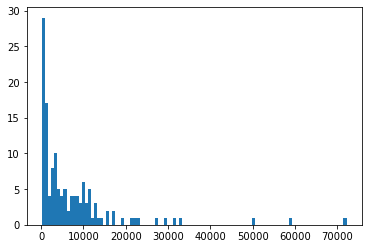

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Quants usuaris diferents compren un item?
counts = np.count_nonzero(df_counts.values, axis=0)
print(counts)
plt.hist(counts, bins=100)
plt.show() #


[10 14  7 ...  9 11  8]


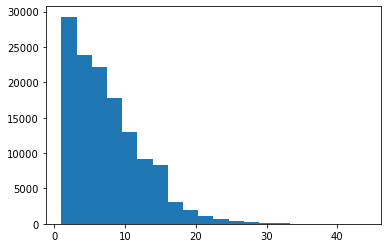

In [8]:
#Quants ítems diferents compra un usuari?
counts = np.count_nonzero(df_counts.values, axis=1)
print(counts)
plt.hist(counts, bins=20)
plt.show() #

## Reducció de dades

In [9]:
#Podem eliminar els usuaris que només han comprat un nombre molt reduït d'ítems (una gran part) o els ítems que compra tothom
"""min_items = 5
max_users = 15000

print(df_counts.shape)

#df_counts = df_counts[np.count_nonzero(df_counts.values, axis=1) > min_items]
df_counts  = df_counts.loc[:, np.count_nonzero(df_counts.values, axis=0) < max_users]

print(df_counts.shape)"""

'min_items = 5\nmax_users = 15000\n\nprint(df_counts.shape)\n\n#df_counts = df_counts[np.count_nonzero(df_counts.values, axis=1) > min_items]\ndf_counts  = df_counts.loc[:, np.count_nonzero(df_counts.values, axis=0) < max_users]\n\nprint(df_counts.shape)'

In [10]:
FRAC = 1
df_reduced = df_counts.sample(frac=FRAC, random_state=1)

## Generació de preddiccions

### Funcions de similitud

In [11]:
# Funcions que calculen les similituds de Pearson i Cosine per saber com s'assembla un usuari a tota la resta
# Estan adaptades per fer les operacions matricialment entre un vector i una matriu
def one_many_cosine(vect_user, counts):
    numerator = np.dot(counts, vect_user)
    
    norm_x = np.linalg.norm(vect_user).astype(np.float32)
    norm_y = np.linalg.norm(counts, axis=1).astype(np.float32)
    denominator = norm_x * norm_y
    
    return np.divide(numerator,denominator,dtype=np.float32)   

def one_many_pearson(vect_user, counts):
    x_mean = vect_user - np.mean(vect_user)
    y_mean = counts - np.mean(counts, axis=1)[:, np.newaxis]
    return one_many_cosine(x_mean, y_mean)

### Fòrmula de predicció de la puntuació

In [12]:
#Calcula score amb la fòrmula inicial
def calc_score(sims, counts):
    return np.dot(sims, counts)/np.sum(sims)

#Calcula l'score amb la segona fòrmula de predicció, va molt pitjor (score = 0.18588)
def calc_score_mean(sims, counts, means, user_id):
    counts_minus_mean = np.zeros(counts.size)
    np.subtract(counts, means, out=counts_minus_mean, where=counts>0)
    return means[user_id]+np.dot(sims, counts_minus_mean)/np.sum(sims)

### Generació de les $N$ recomanacions

In [13]:
# Recomana n items sense calcular similarities
def one_many_recommend_n_items(user_id, df, N):
    user_items = df.loc[user_id] #Agafem el counts de l'user que volem
    non_scored = user_items[df.loc[user_id] == 0] #Mirem quins elements no ha comprat
    
    idx_user = df.index.get_loc(user_id) #Obtenim l'índex de l'usuari
    
    similarities = one_many_cosine(df.values[idx_user], df.values) #Calculem la similitud de l'user amb tota la resta d'usuaris
    #similarities = one_many_pearson(df.values[idx_user], df.values)
    similarities[idx_user] = 0 #La similaritat amb ell mateix és 0
    
    scores = [(calc_score(similarities, df[item]), item) for item in non_scored.index] #Calculem l'score de cada ítem que no ha comprat
    scores.sort(reverse=True) #Ordenem 
    return [pair[1] for pair in scores[:N]] #Retornem la segona component dels N millors

#Recomana n items amb la fòrmula de la mitjana
def one_many_recommend_n_items_means(user_id, df, means, N):
    user_items = df.loc[user_id]
    non_scored = user_items[df.loc[user_id] == 0]
    idx_user = df.index.get_loc(user_id)
    similarities = one_many_cosine(df.values[idx_user], df)
    similarities[idx_user] = 0
    scores = [(calc_score_mean(similarities, df[item], means, user_id), item) for item in non_scored.index]
    scores.sort(reverse=True)
    return [pair[1] for pair in scores[:N]]

# Recomana n ítems usant només els n_close usuaris més similars
def one_many_recommend_n_items_close(user_id, df, n_close, N):
    user_items = df.loc[user_id] #Agafem el counts de l'user que volem
    non_scored = user_items[df.loc[user_id] == 0] #Mirem quins elements no ha comprat
    
    idx_user = df.index.get_loc(user_id) #Obtenim l'índex de l'usuari
    
    similarities = one_many_cosine(df.values[idx_user], df.values) #Calculem la similitud de l'user amb tota la resta d'usuaris
    #similarities = one_many_pearson(df.values[idx_user], df.values)
    similarities[idx_user] = 0 #La similaritat amb ell mateix és 0
    
    #Agafem els índexs dels n usuaris que s'assemblen més a user_id
    best_n_matches = np.argsort(similarities)[::-1][:n_close]
    #Reduïm similarities a les dels millors
    best_sim = [similarities[i] for i in best_n_matches]
    
    #Calculem les scores limitant també els items de l'usuari
    scores = []
    for item in non_scored.index:
        items = [df[item].values[i] for i in best_n_matches]
        scores.append((calc_score(best_sim, items), item))
    
    scores.sort(reverse=True) #Ordenem 
    return [pair[1] for pair in scores[:N]] #Retornem la segona component dels N millors

In [14]:
one_many_recommend_n_items_close(df_reduced.index[0], df_reduced, 10, 10)

[77, 91, 124, 24, 43, 26, 65, 108, 84, 69]

## Kaggle

In [15]:
df_test_products = pd.read_csv(join('data', 'order_products__test.csv'))
df_test_orders = pd.read_csv(join('data', 'orders__test.csv'))[['order_id', 'user_id']]
df_test_merged = merge_information(df_test_products, df_test_orders, df_prods)

df_test_counts = build_counts_table(df_test_merged)
df_all = df_reduced.append(df_test_counts)
df_all = df_all.fillna(0)

In [16]:
#Aquest fa servir el recomment one to many (no fa servir tanta memòria, però triga bastant)
df_submission = pd.DataFrame(columns=['user_id', 'products_list'])

means = np.true_divide(df_all.sum(1),(df_all!=0).sum(1))
for user_id in df_test_counts.index:
    #user_recos = one_many_recommend_n_items(user_id, df_all, 5)
    #user_recos = one_many_recommend_n_items_means(user_id, df_all, means, 5)
    user_recos = one_many_recommend_n_items_close(user_id, df_all, int(0.005*df_all.shape[0]), 5)

    df_submission = df_submission.append(
        {
            'user_id': user_id,
            'products_list': ' '.join(map(str, user_recos))
        }, 
        ignore_index=True)

df_submission.to_csv('submission_1cos05percent.csv', index=None)

In [17]:
print(df_submission.head())

  user_id      products_list
0  300000    83 84 121 91 88
1  300001   21 120 112 96 84
2  300002    83 112 78 91 96
3  300003  120 108 115 31 72
4  300004    24 83 21 112 96
